Modified "Tutorial 1: How to use abcTau package to fit autocorrelations or PSDs" from the abcTau repo


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns 

import pickle
import numpy as np
import pandas as pd
from scipy import stats

# add the path to the abcTau package
import sys
#sys.path.append('./abcTau')
sys.path.append('C:\\Users\\ipochino\\AppData\\Local\\anaconda3\\envs\\isttc\\Lib\\site-packages\\abcTau') # IP: replaced previous line with that; relative path was not working
import abcTau

In [8]:
dataset_folder = 'E:\\work\\q_backup_06_03_2025\\projects\\isttc\\synthetic_dataset\\'
results_folder = 'D:\\intr_timescales\\abcTau_tests\\'

datasave_path = results_folder + 'synthetic_dataset/'
# path and filename to save the intermediate results after running each step
inter_save_direc = results_folder + 'synthetic_dataset/'

filenameSave = 'test'
inter_filename = 'abc_intermediate_results'

(500, 1000)


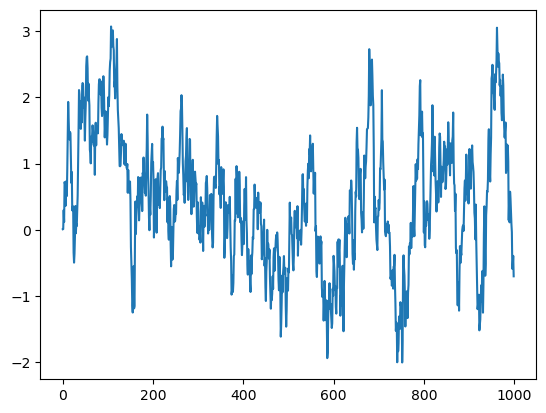

In [7]:
data_load = np.load(dataload_path + filename + '.npy')
print(data_load.shape)

plt.plot(data_load[0, :])

In [14]:
with open(dataset_folder + 'spike_trains.pkl','rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [27]:
spike_trains[0]

array([5.89825416e+02, 5.90332951e+02, 2.48013326e+03, ...,
       5.98805689e+05, 5.98817222e+05, 5.98824358e+05])

In [29]:
spike_train[-1]

np.float64(598824.3581617338)

In [38]:
spike_indices.shape

(4596,)

In [36]:
idx = 0
spike_train = spike_trains[idx]
print(spike_train.shape)

binary_train = np.zeros(duration_ms, dtype=int)
spike_indices = spike_train.astype(int)
binary_train[spike_indices] = 1
print(binary_train.shape)

spike_trains_reshaped = binary_train[np.newaxis, :] # abcTau expects numTrials, numTimePoints = np.shape(data)
print(f'FR {fr_values[idx]}, true TAU {taus_ms[idx]}, alpha {alphas[idx]}')
spike_trains_reshaped.shape

np.count_nonzero(spike_trains_reshaped)

(4596,)
(600000,)
FR 7.741820925074074, true TAU 150.92351520169404, alpha 0.851098588294361


4324

In [34]:
np.count_nonzero(spike_trains_reshaped)

4324

### Step 1: Extracting required statistics from real data

First load your data and use "extract_stats" functions to compute statistics.

(4596,)
(20,)


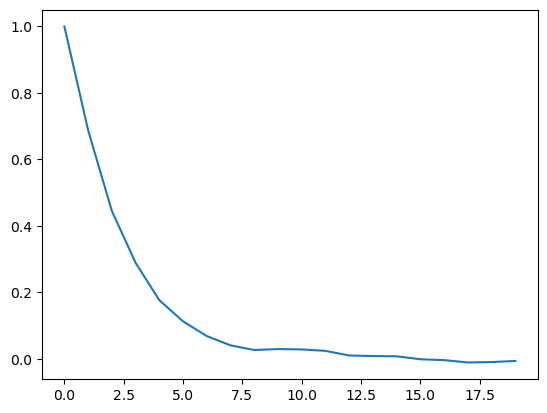

In [40]:
#---------- extract statistics from real data
# select summary statistics metric
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
deltaT = 1 # temporal resolution of data.
binSize = 50 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the dispersion parameter if computed with grid-search
maxTimeLag = 1000 # only used when using autocorrelation for summary statistics
lm = round(maxTimeLag/binSize) # maximum bin for autocorrelation computation
data_sumStat, data_mean, data_var, T, numTrials = abcTau.preprocessing.extract_stats(spike_trains_reshaped, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)

print(spike_train.shape)
print(data_sumStat.shape)

plt.plot(data_sumStat)

### Step 3: Estimation of timescales using the aABC algorithm

Fitting one timescale in time domain

The duration for fitting the generative model with the aABC algorithm depends on the size of your data, selected summary statistics (e.g., fastest is with the PSD), number of accepted samples in posteriors (min_samples), final selected accepatance rate (minAccRate), and computational resources (e.g., number of cores in parallel processing). Depending on these parameters the fitting duration is in between ~5-20 min (usually for fitting PSD as summary statistic and parallel processing, see Supplementary Table 1 in the paper for more details) up to ~4-8 hours (wihtout any parallel processing).

In [42]:
# 4. Select the desired generative model from the list of 'generative_models.py' and the distance function from 'diatance_functions.py'
# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'linear_distance'

# 5. Define the prior distributions
# Define a uniform prior distribution over the given range
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 400.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]

# 6. Set the aABC fitting parameters
# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)

In [43]:
# 7. Create the model object: Just copy paste the following (this a general definition of the model object, but all parts 
# including generative models, summary statistics computation or distance function can be replaced by your own functions. 
# You can add your handmade functions inside respected modules: "generative_models.py", "distance_functions.py", "summary_stats.py")

# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

In [ ]:
# 8. Run the aABC algorithm and save the results
# fit with aABC algorithm for any generative model
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc, inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

Starting step 0
epsilon = 1


### Plotting the results

(took examples from other tutorials - I downloaded them before)

In [ ]:
# load abc results
filename = 'OU_tau20_mean0_var1_rawData_steps30'
abc_results = np.load(datasave_path + filename + '.npy', allow_pickle=True)
ind = filename.find('steps') 
final_step = int(filename[ind+5] + filename[ind+6])

# extract estimated parameters
theta_accepted = abc_results[final_step-1]['theta accepted']
tau1 = theta_accepted[0]

# extract the development of the error threshold and acceptance rate during fitting (discarding first iteration)
eps = []
accR = []
steps = np.arange(1,final_step+1)[1:]
for i in range(final_step): 
    step_results = abc_results[i]
    eps.append(step_results['epsilon'])
    accR.append(step_results['n accepted']/step_results['n total'])
eps = eps[1:]
accR = accR[1:]

# ground truth values 
tau1_gt = 20

In [ ]:
# plot the results
fig = plt.figure(figsize = (24,6))

# plotting variables
cABC = 'darkorange'
ctheor = 'gray'
cAccR = 'r'
cErr = 'b'
a = 0.5
lw = 3

ax = plt.subplot(141)
ax.hist(tau1, facecolor= cABC, density=True, alpha = a, label = r'Estimated')
sns.kdeplot(tau1, color = cABC)
plt.axvline(tau1_gt, color = ctheor, label = r'Ground truth', linewidth = lw, linestyle = '--')

ax.set_xlabel(r'$\tau_1$ [ms]')
ax.set_ylabel('Probability density')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(0.4, 1))

fig.tight_layout()